In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Logistic regression

## 1) Linear classifier

We want to predict the admission of some students to a school based on their score to two exams. Let's get a training set.

In [160]:
data = pd.read_csv("machine-learning-ex2/ex2/ex2data1.txt", names=["score1", "score2", "admission"])
data.head(5)

,score1,score2,admission
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


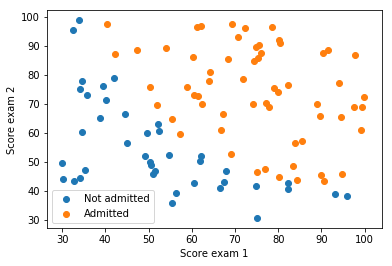

In [161]:
fig,ax = plt.subplots()
ax.scatter(data.loc[data.admission==0].score1, data.loc[data.admission==0].score2, label="Not admitted")
ax.scatter(data.loc[data.admission==1].score1, data.loc[data.admission==1].score2, label="Admitted")
ax.set_xlabel("Score exam 1")
ax.set_ylabel("Score exam 2")
ax.legend();

We want to train a model to classify the students on this dataset, and we could use logistic regression for that.

The model will be of the form $h_0(x)=g(\theta^Tx)$ with $g(z)=\frac{1}{1+e^{-z}}$ being the logistic (sigmoid) function.

Let's first define a fuction for the sigmoid function:

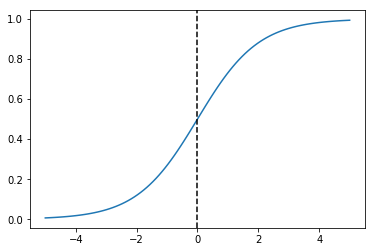

In [162]:
sigmoid = lambda z: 1/(1+np.exp(-z))

x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x))
plt.axvline(0, ls="--", color="k")

Great, that looks about right.

Now, for our model, we will use a cost function $J(\theta)$ of the form:

$J(\theta)=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)}))-(1-y^{(i)})log(1-h_\theta(x^{(i)}))]$

Let's define it:

In [163]:
def cost(theta, features, target):
    pred = np.dot(features, theta[:, np.newaxis])
    return np.sum(-target*np.log(sigmoid(pred))-(1-target)*np.log(1-sigmoid(pred)))/len(features)

We will need to minimize this function.

Using `scipy`, we have access to a lot of tools for this in the `scipy.optimize` module.

The `scipy.optimize.minimize` is a high-level interface that lets you choose from a broad range of solvers. Some of those solvers can take the gradient information as argument, some of them don't need it (Nelder–Mead).

Still, let's define the gradient for our cost function, so we can have access to a lot more solvers algorithms.

For our cost function $J(\theta)=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)}))-(1-y^{(i)})log(1-h_\theta(x^{(i)}))]$, 
the gradient is a vector of the same length as $\theta$ where the $j^{th}$ element (for j=0,1, ....n) is defined as:

$\frac{\delta J(\theta)}{\delta\theta_j}=\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$

Let's write a function for this gradient.

 

In [164]:
def gradientCost(theta, features, target):
    pred = np.dot(features, theta[:, np.newaxis])
    return np.sum((sigmoid(pred)-target)*features, axis=0)/len(features)

Alright, we can now minimize our cost function with whatever algorithm we want. The list of possible solvers to use is:

- 'Nelder-Mead'
- 'Powell'
- 'CG' 
- 'BFGS'
- 'Newton-CG'
- 'L-BFGS-B'
- 'TNC'
- 'COBYLA'
- 'SLSQP'
- 'trust-constr'
- 'dogleg'
- 'trust-ncg'
- 'trust-exact'
- 'trust-krylov'
- custom - a callable object

In [165]:
import scipy.optimize as opt 

initialTheta = np.zeros(3) # initial guesses for theta
features = np.hstack([np.ones(len(data))[:, np.newaxis], data[["score1", "score2"]].values])
target = data.admission.values[:, np.newaxis]

res = opt.minimize(cost, initialTheta, jac=gradientCost, args=(features, target), method='BFGS')
best = res.x
print(res)
print(f"Best parameters: {best}")

      fun: 0.2034977015894438
 hess_inv: array([[ 3.31474479e+03, -2.63892205e+01, -2.70237122e+01],
       [-2.63892205e+01,  2.23869433e-01,  2.02682332e-01],
       [-2.70237122e+01,  2.02682332e-01,  2.35335117e-01]])
      jac: array([-9.52476822e-09, -9.31921318e-07, -2.82608930e-07])
  message: 'Optimization terminated successfully.'
     nfev: 31
      nit: 23
     njev: 31
   status: 0
  success: True
        x: array([-25.16133284,   0.2062317 ,   0.2014716 ])
Best parameters: [-25.16133284   0.2062317    0.2014716 ]


/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


In [166]:
print(f"Cost with initial parameters: {cost(np.zeros(3), features, target)}")
print(f"Cost with best parameters found: {cost(best, features, target)}")

Cost with initial parameters: 0.6931471805599453
Cost with best parameters found: 0.2034977015894438


Let's see what boundary those parameters are defining for our training data:

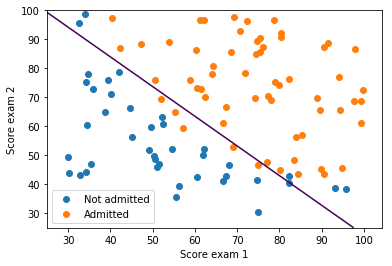

In [93]:
# Define a space over which we will calculate the predictions
xtest = np.linspace(25, 100, 500)
ytest = np.linspace(25, 100, 500)
X,Y = np.meshgrid(xtest, ytest)
spacePredictions = sigmoid(best[0]+best[1]*X+best[2]*Y)

fig,ax = plt.subplots()
ax.scatter(data.loc[data.admission==0].score1, data.loc[data.admission==0].score2, label="Not admitted")
ax.scatter(data.loc[data.admission==1].score1, data.loc[data.admission==1].score2, label="Admitted")
ax.set_xlabel("Score exam 1")
ax.set_ylabel("Score exam 2")
ax.contour(X, Y, spacePredictions, levels=[0.5])
ax.legend();

That doesn't look that bad.

What is the accuracty on our model on the training set? Let's calculate this by predicting for every student if they'll be admitted or not and let's compare with their actual admission status.

In [94]:
# predictions (those will be a probability of being admitted)
predictions = sigmoid(np.dot(features, best[:, np.newaxis]))

# We'll consider a probability>0.5 as an admission. So we'll just round the predictions to 
# get either 0 or 1.
accuracy = np.sum(np.round(predictions).astype(int)==target)/len(target)
print(f"Accuracy of the model: {100*accuracy}%")

Accuracy of the model: 89.0%


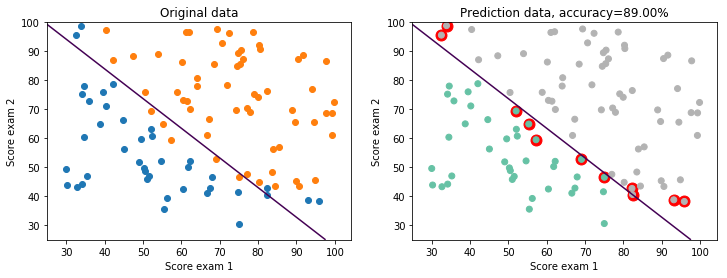

In [107]:
# area for decision boundary
xtest = np.linspace(25, 100, 500)
ytest = np.linspace(25, 100, 500)
X,Y = np.meshgrid(xtest, ytest)
spacePredictions = sigmoid(best[0]+best[1]*X+best[2]*Y)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Real categories and boundary lines
ax1.scatter(data.loc[data.admission==0].score1, data.loc[data.admission==0].score2, label="Not admitted")
ax1.scatter(data.loc[data.admission==1].score1, data.loc[data.admission==1].score2, label="Admitted")
ax1.set_title("Original data")

# Predictions
misClassified = data.loc[np.ravel(np.round(predictions).astype(int)!=target)]
ax2.scatter(misClassified.score1, misClassified.score2, c="red", s=120)
ax2.scatter(data.score1, data.score2, c=np.ravel(np.round(predictions).astype(int)), cmap="Set2")
ax2.set_title(f"Prediction data, accuracy={100*accuracy:.2f}%")

for ax in [ax1, ax2]:
    ax.contour(X, Y, spacePredictions, levels=[0.5])
    ax.set_xlabel("Score exam 1")
    ax.set_ylabel("Score exam 2")


## 2) One vs All

This exercice just had us classify the students in two categories, so one boundary was enough to delimitate the two groups.

What if we had in fact more than two groups in our data?

Let's make some fake data reflecting that:

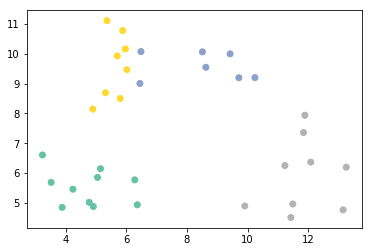

In [108]:
# let's construct 4 clusters
from scipy import stats

def createCluster(n, cat, x, y, dx=1, dy=1):
    return np.hstack([stats.norm(loc=x, scale=dx).rvs(n)[:, np.newaxis], stats.norm(loc=y, scale=dy).rvs(n)[:, np.newaxis], (np.zeros(n)+cat)[:, np.newaxis]])


data2 = np.vstack([createCluster(n, i, x, y) for i,(n,x,y) in enumerate(zip([10, 7, 8, 9], [5, 9, 5, 12], [5, 10, 9, 6]))])
plt.scatter(data2[:, 0], data2[:, 1], c=data2[:, 2], cmap="Set2")

The strategy here will be to perform for each different category a One versus All classification. For each data point, we will then obtain the probability of being of a certain category membership, and we will just take the highest probability as the prediction for the data point.

In [109]:
# number of different categories present in dataset
nCat = len(np.unique(data2[:,2]))

features = np.hstack([np.ones(len(data2))[:, np.newaxis], data2[:, :2]])
initialTheta = np.zeros(3)

# result array for the theta for each boundary decision
resTheta = np.zeros((nCat, 3))

# let's get the best theta vector to categorize each category agains the rest
for i in range(nCat):
    target = (data2[:, 2]==i)[:, np.newaxis].astype(int)
    result = minimize(cost, initialTheta, jac=gradientCost, args=(features, target), method='L-BFGS-B')
    if result.success:
        resTheta[i]= result.x
        print(f"Best parameters for iteration {i}: {result.x}")
    else:
        print(f"Iteration {i} did not converge")

Best parameters for iteration 0: [112.23710193  -6.91863402 -10.63215387]
Best parameters for iteration 1: [-23.4426891    0.78466754   1.77981362]
Best parameters for iteration 2: [-8.89285684 -2.07897074  2.37654932]
Best parameters for iteration 3: [-10.47783689  11.31207726 -14.37603163]


/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


It looks like all our minimizations have converged.
Let's compute the prediction from those Theta for each data point.

In [110]:
predictions = sigmoid(np.dot(features, resTheta.transpose()))
predictedCat = np.where(predictions == predictions.max(axis=1)[:, np.newaxis])[1]
final = pd.DataFrame(np.hstack([data2, predictedCat[:, np.newaxis]]), columns=["x", "y", "category", "predictedCat"])
accuracy2 = np.sum(final.category==final.predictedCat)/len(final)
print(f"accuracy: {100*accuracy}%")
final

accuracy: 89.0%


,x,y,category,predictedCat
0,6.284024,5.766586,0.0,0.0
1,3.237694,6.604208,0.0,0.0
2,4.242113,5.453695,0.0,0.0
3,3.887687,4.843255,0.0,0.0
4,4.779418,5.013457,0.0,0.0
5,5.055150,5.850720,0.0,0.0
6,4.915354,4.871909,0.0,0.0
7,5.153058,6.141797,0.0,0.0
8,6.365095,4.929764,0.0,0.0
9,3.524713,5.683898,0.0,0.0


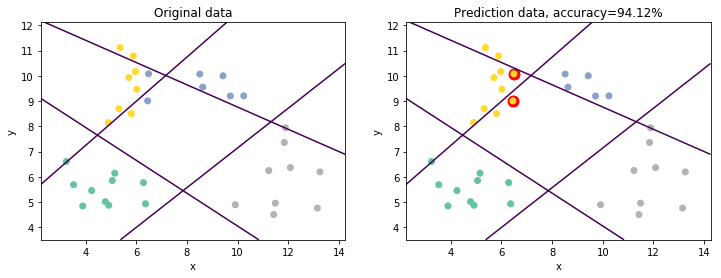

In [112]:
# area for decision boundary
xSpace = np.linspace(data2[:, 0].min()-1, data2[:, 0].max()+1, 100)
ySpace = np.linspace(data2[:, 1].min()-1, data2[:, 1].max()+1, 100)
X,Y = np.meshgrid(xSpace, ySpace)

spacePredictions = [sigmoid(resTheta[i][0]+resTheta[i][1]*X+resTheta[i][2]*Y) for i in range(nCat)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Real categories and boundary lines
ax1.scatter(data2[:, 0], data2[:, 1], c=data2[:, 2], cmap="Set2")
ax1.set_title("Original data")

# Predictions
misClassified = final[final.category!=final.predictedCat]
ax2.scatter(misClassified.x, misClassified.y, c="red", s=120)
ax2.scatter(data2[:, 0], data2[:, 1], c=final.predictedCat, cmap="Set2")
ax2.set_title(f"Prediction data, accuracy={100*accuracy2:.2f}%")

for ax in [ax1, ax2]:
    for i in range(nCat):
        ax.contour(X, Y, spacePredictions[i], levels=[0.5])
    ax.set_xlabel("x")
    ax.set_ylabel("y")


# Regularization

Now that we have a working implementation of logistic regression, we are going to improve the algorithm by adding regularization. Regularization consists of adding a term in the cost function that will cause the algorithm to decrease the weight of each coefficient ($\theta$) resulting in smaller coefficients and thus limiting the complexity of the model.

In theory this this helps minimize overfitting and improve the model's ability to generalize. 

To test regularization on logistic regression, we are going to use a slightly more challenging problem. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a data set of test results on past microchips, from which you can build a logistic regression model.

In [245]:
data3 = pd.read_csv("machine-learning-ex2/ex2/ex2data2.txt", names=["test1", "test2", "valid"])
data.head(5)

,score1,score2,admission
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


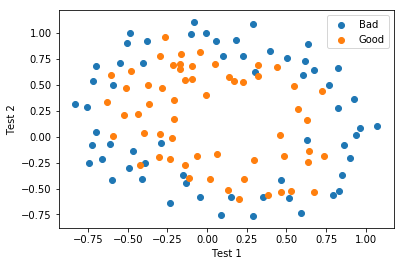

In [246]:
fig,ax = plt.subplots()
ax.scatter(data3.loc[data3.valid==0].test1, data3.loc[data3.valid==0].test2, label="Bad")
ax.scatter(data3.loc[data3.valid==1].test1, data3.loc[data3.valid==1].test2, label="Good")
ax.set_xlabel("Test 1")
ax.set_ylabel("Test 2")
ax.legend();

Well it seems that there is no linear decision boundary that will perform well on this data as the dataset cannot be separated into positive and negative examples by a straight-line through the plot. One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features. 

In practice, we can use **feature mapping** to create more polynomial features from each data point to feed into the classifier.

Let's apply feature mapping and create all the polynomial terms up to the sixth power for every feature.

Note that while the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting.

In [249]:
degree = 7

# this is what the polynomial features will look like, x1=test1 and x2=test2
labels = [f"x1^{i-j}.x2^{j}" for i in range(0,degree) for j in range(0,i+1)]
labels

['x1^0.x2^0',
 'x1^1.x2^0',
 'x1^0.x2^1',
 'x1^2.x2^0',
 'x1^1.x2^1',
 'x1^0.x2^2',
 'x1^3.x2^0',
 'x1^2.x2^1',
 'x1^1.x2^2',
 'x1^0.x2^3',
 'x1^4.x2^0',
 'x1^3.x2^1',
 'x1^2.x2^2',
 'x1^1.x2^3',
 'x1^0.x2^4',
 'x1^5.x2^0',
 'x1^4.x2^1',
 'x1^3.x2^2',
 'x1^2.x2^3',
 'x1^1.x2^4',
 'x1^0.x2^5',
 'x1^6.x2^0',
 'x1^5.x2^1',
 'x1^4.x2^2',
 'x1^3.x2^3',
 'x1^2.x2^4',
 'x1^1.x2^5',
 'x1^0.x2^6']

With this scheme, we'll have 28 features. Let's apply it to our data:

In [256]:
featuresDf = pd.DataFrame(np.hstack([(data3.test1[:, np.newaxis]**(i-j))*(data3.test2[:, np.newaxis]**j) for i in range(0,degree) for j in range(0,i+1)]), columns=labels)
featuresDf.head()

,x1^0.x2^0,x1^1.x2^0,x1^0.x2^1,x1^2.x2^0,x1^1.x2^1,x1^0.x2^2,x1^3.x2^0,x1^2.x2^1,x1^1.x2^2,x1^0.x2^3,...,x1^2.x2^3,x1^1.x2^4,x1^0.x2^5,x1^6.x2^0,x1^5.x2^1,x1^4.x2^2,x1^3.x2^3,x1^2.x2^4,x1^1.x2^5,x1^0.x2^6
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


We now need to add the regularization term to our cost function. The regularization will be $\frac{\lambda}{2m}\theta_j$ for each $\theta_j^2$.

So the regularized cost function for the logistic regression becomes:

$J(\theta)=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)}))-(1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \sum_{j=1}^n\frac{\lambda}{2m}\theta_j^2$

Here, you'll note that we are not regularizing $\theta_0$ (which is associated with the "=1" feature). In practice this regularizing it would not change much, but this is the convention.

The gradient for this regularized cost function is a vector of the same length as $\theta$ where the $j^{th}$ element (for j=0,1, ....n) is defined as:

$\frac{\delta J(\theta)}{\delta\theta_j}=\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$ for $j=0$

$\frac{\delta J(\theta)}{\delta\theta_j}=\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j$ for $j\geq1$

In [227]:
def costRegularized(theta, features, target, regCoef):
    pred = np.dot(features, theta[:, np.newaxis])
    m = len(features)
    regularization = (regCoef/(2*m))*np.sum(np.concatenate([[0], np.ones(len(theta)-1)])*theta**2)
    return np.sum(-target*np.log(sigmoid(pred))-(1-target)*np.log(1-sigmoid(pred)))/m + regularization

def gradientCostRegularized(theta, features, target, regCoef):
    pred = np.dot(features, theta[:, np.newaxis])
    m = len(features)
    regularization = np.concatenate([[0], np.ones(len(theta)-1)])*theta*regCoef/m
    return np.sum((sigmoid(pred)-target)*features, axis=0)/m + regularization


Let's start with no regularization by setting $\lambda=0$

In [282]:
import scipy.optimize as opt 

lambdaCoef = 0
features = featuresDf.values#np.hstack([(data3.test1[:, np.newaxis]**(i-j))*(data3.test2[:, np.newaxis]**j) for i in range(0,degree) for j in range(0,i+1)])

initialTheta = np.zeros(features.shape[1]) # initial guesses for theta
target = data3.valid.values[:, np.newaxis]

res = opt.minimize(costRegularized, initialTheta, jac=gradientCostRegularized, args=(features, target, lambdaCoef), method='BFGS')
best = res.x
# print(res)
print(f"Best parameters: {best}")
print(f"The cost went from {costRegularized(np.zeros(features.shape[1]), features, target, lambdaCoef):.3f} to {costRegularized(best, features, target, lambdaCoef):.3f} during the optimization")

Best parameters: [   35.10190793    44.11915333    69.2718879   -344.27902622
  -198.23460202  -184.22839294  -295.82037319  -621.73276682
  -510.84939866  -328.31190571  1094.70024395  1269.5858424
  1757.74899021   900.93785499   436.58885494   471.1202704
  1236.23874885  1822.8205635   1929.66798882  1131.05342984
   463.79942203 -1142.11729129 -2020.95918976 -3463.39988937
 -3484.51090412 -3252.26786983 -1546.00959565  -510.4127944 ]
The cost went from 0.693 to 0.225 during the optimization


Let's visualize what boundary it found:

/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


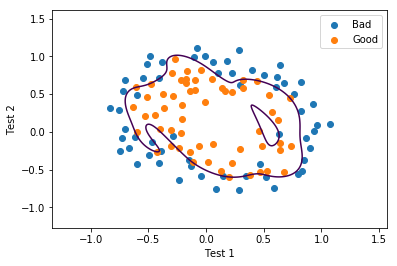

In [283]:
xSpace = np.linspace(data3.test1.min()-0.5, data3.test1.max()+0.5, 500)
ySpace = np.linspace(data3.test2.min()-0.5, data3.test2.max()+0.5, 500)
X,Y = np.meshgrid(xSpace, ySpace)

spacePredictions = sigmoid( np.sum( best[np.newaxis, np.newaxis, :]*np.stack([(X**(i-j))*(Y**j) for i in range(0,degree) for j in range(0,i+1)], axis=2), axis=2) )

fig,ax = plt.subplots()
ax.scatter(data3.loc[data3.valid==0].test1, data3.loc[data3.valid==0].test2, label="Bad")
ax.scatter(data3.loc[data3.valid==1].test1, data3.loc[data3.valid==1].test2, label="Good")
ax.set_xlabel("Test 1")
ax.set_ylabel("Test 2")
ax.contour(X, Y, spacePredictions, levels=[0.5])
ax.legend();

What about the accuracy?

In [284]:
# predictions (those will be a probability of being admitted)
predictions = sigmoid(np.dot(features, best[:, np.newaxis]))

# We'll consider a probability>0.5 as an admission. So we'll just round the predictions to 
# get either 0 or 1.
accuracy = np.sum(np.round(predictions).astype(int)==target)/len(target)
print(f"Accuracy of the model: {100*accuracy}%")

Accuracy of the model: 91.52542372881356%


Well, of course we got a very good accuracty because the model has overfitted the data, and we can bet that this model cannot be generalized to another dataset.

Let's introduce our $\lambda$ regularization factor, and let's try several values.

/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


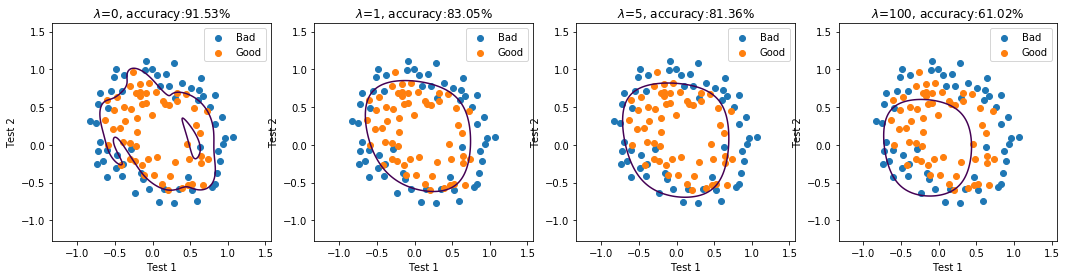

In [292]:
features = np.hstack([(data3.test1[:, np.newaxis]**(i-j))*(data3.test2[:, np.newaxis]**j) for i in range(0,degree) for j in range(0,i+1)])
target = data3.valid.values[:, np.newaxis]
initialTheta = np.zeros(features.shape[1])

xSpace = np.linspace(data3.test1.min()-0.5, data3.test1.max()+0.5, 500)
ySpace = np.linspace(data3.test2.min()-0.5, data3.test2.max()+0.5, 500)
X,Y = np.meshgrid(xSpace, ySpace)

fig,axes = plt.subplots(ncols=4, figsize=(18, 4))

for i,lambdaCoef in enumerate([0, 1, 5, 100]):
    res = opt.minimize(costRegularized, initialTheta, jac=gradientCostRegularized, args=(features, target, lambdaCoef), method='BFGS')
    best = res.x
    spacePredictions = sigmoid( np.sum( best[np.newaxis, np.newaxis, :]*np.stack([(X**(i-j))*(Y**j) for i in range(0,degree) for j in range(0,i+1)], axis=2), axis=2) )
    
    # accuracy?
    predictions = sigmoid(np.dot(features, best[:, np.newaxis]))
    accuracy = np.sum(np.round(predictions).astype(int)==target)/len(target)
    
    axes[i].scatter(data3.loc[data3.valid==0].test1, data3.loc[data3.valid==0].test2, label="Bad")
    axes[i].scatter(data3.loc[data3.valid==1].test1, data3.loc[data3.valid==1].test2, label="Good")
    axes[i].contour(X, Y, spacePredictions, levels=[0.5])
    axes[i].set_title(f"$\lambda$={lambdaCoef}, accuracy:{100*accuracy:.2f}%")

for ax in axes:
    ax.set_xlabel("Test 1")
    ax.set_ylabel("Test 2")
    ax.legend();

Great, we see that regularization is working, the model is "simplified" as soon as we introduce $\lambda$. However, we also see that if $\lambda$ is set too high, the model will underfit the data!